# Adversarial Attacks on MNIST

- FGSM (Fast Gradient Sign Method) - Untargeted
- PGD (Projected Gradient Descent) - Untargeted
- Carlini & Wagner (C&W) - Targeted



## 1. Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

## 2. Load MNIST and Define a Simple CNN

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

100%|██████████| 9.91M/9.91M [00:09<00:00, 1.10MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 214kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 597kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.08MB/s]


In [3]:
# Instantiate and train the model (for demonstration, train for 1 epoch)
model = SimpleCNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (1 epoch for speed)
model.train()
for epoch in range(1):
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

## 3. Evaluate Model Accuracy on Clean Test Set

In [4]:
def test(model, device, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test set: Accuracy: {accuracy:.2f}%')
    return accuracy

clean_acc = test(model, device, test_loader)

Test set: Accuracy: 98.00%


## 4. FGSM Attack
The Fast Gradient Sign Method perturbs the input in the direction of the gradient of the loss with respect to the input.

In [5]:
def fgsm_attack(model, data, target, epsilon):
    # Clone the data to make it a leaf tensor
    data = data.clone().detach()
    data.requires_grad = True
    output = model(data)
    loss = F.cross_entropy(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    perturbed_data = data + epsilon * data_grad.sign()
    perturbed_data = torch.clamp(perturbed_data, 0, 1)
    return perturbed_data

In [6]:
# Test FGSM on a batch
model.eval()
data, target = next(iter(test_loader))
data, target = data.to(device), target.to(device)
epsilon = 0.25
perturbed_data = fgsm_attack(model, data, target, epsilon)
output = model(perturbed_data)
pred = output.argmax(dim=1)
misclassified = (pred != target)
print(f"FGSM misclassification rate: {misclassified.float().mean().item()*100:.2f}%")

FGSM misclassification rate: 85.60%


### FGSM Visualization

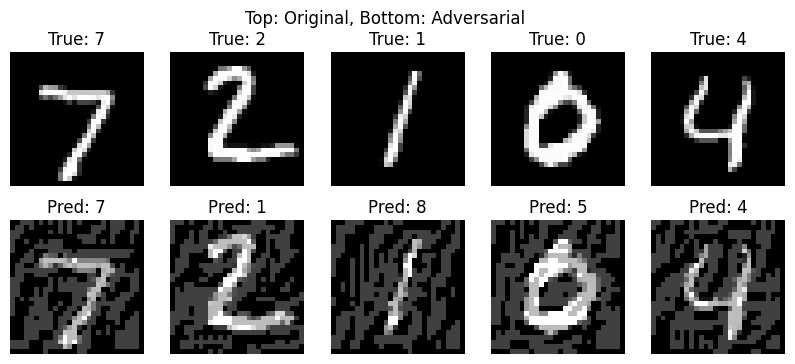

In [7]:
def plot_adversarial_examples(orig, adv, labels, preds, n=5):
    # Use the minimum of n and the actual number of samples
    n = min(n, len(orig))
    plt.figure(figsize=(10, 4))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(orig[i].cpu().detach().squeeze(), cmap='gray')
        plt.title(f"True: {labels[i].item()}")
        plt.axis('off')
        plt.subplot(2, n, n+i+1)
        plt.imshow(adv[i].cpu().detach().squeeze(), cmap='gray')
        plt.title(f"Pred: {preds[i].item()}")
        plt.axis('off')
    plt.suptitle('Top: Original, Bottom: Adversarial')
    plt.show()

plot_adversarial_examples(data, perturbed_data, target, pred)

## 5. PGD Attack
Projected Gradient Descent is an iterative version of FGSM.

In [8]:
def pgd_attack(model, data, target, epsilon, alpha, iters):
    # Clone the data to make it a leaf tensor
    data = data.clone().detach()
    perturbed_data = data.clone().detach()
    perturbed_data.requires_grad = True
    for i in range(iters):
        output = model(perturbed_data)
        loss = F.cross_entropy(output, target)
        model.zero_grad()
        loss.backward()
        adv_grad = perturbed_data.grad.data
        perturbed_data = perturbed_data + alpha * adv_grad.sign()
        perturbed_data = torch.max(torch.min(perturbed_data, data + epsilon), data - epsilon)
        perturbed_data = torch.clamp(perturbed_data, 0, 1).detach()
        perturbed_data.requires_grad = True
    return perturbed_data

PGD misclassification rate: 95.90%


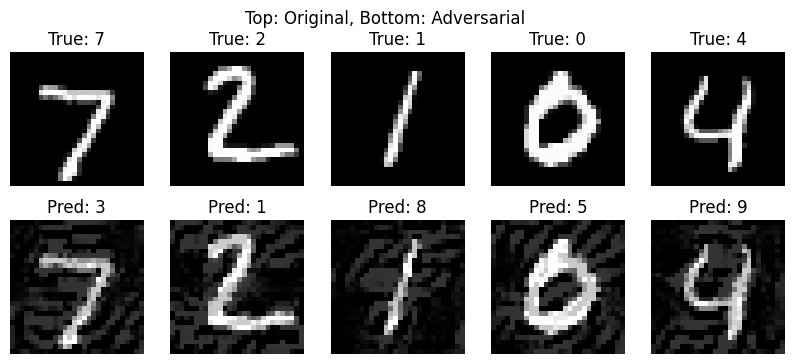

In [9]:
alpha = 0.01
iters = 20
perturbed_data_pgd = pgd_attack(model, data, target, epsilon, alpha, iters)
output_pgd = model(perturbed_data_pgd)
pred_pgd = output_pgd.argmax(dim=1)
misclassified_pgd = (pred_pgd != target)
print(f"PGD misclassification rate: {misclassified_pgd.float().mean().item()*100:.2f}%")
plot_adversarial_examples(data, perturbed_data_pgd, target, pred_pgd)

## 6. Carlini & Wagner (C&W) Attack
The C&W attack is an optimization-based attack that minimizes the perturbation while ensuring misclassification.

In [10]:
def cw_attack(model, data, target, c=1.0, kappa=0, steps=100, lr=0.01):

    model.eval()
    batch_size = data.size(0)

    # Initialize w as inverse tanh of original image
    eps = 1e-6
    w = torch.atanh((data * 2 - 1) * (1 - eps)).detach()   
    w.requires_grad = True

    optimizer = torch.optim.Adam([w], lr=lr)

    for step in range(steps):
        # Transform w to image space
        x = 0.5 * (torch.tanh(w) + 1)

        # Forward pass
        output = model(x)

        # L2 distance
        l2_dist = torch.sum((x - data) ** 2, dim=[1, 2, 3])

        # Classification loss
        target_logit = output[torch.arange(batch_size), target]
        other_logits = output.clone()
        other_logits[torch.arange(batch_size), target] = -float('inf')
        max_other_logit = torch.max(other_logits, dim=1)[0]
        classification_loss = torch.clamp(max_other_logit - target_logit + kappa, min=0)

        # Combine losses
        total_loss = (l2_dist + c * classification_loss).mean()

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if step % 20 == 0:
            print(f"Step {step}, Loss: {total_loss.item():.4f}")

    return 0.5 * (torch.tanh(w) + 1)


torch.Size([1000, 1, 28, 28])

Step 0, Loss: 1075.1920
Step 20, Loss: 951.4690
Step 40, Loss: 812.6636
Step 60, Loss: 653.1415
Step 80, Loss: 477.6468
Step 100, Loss: 302.4451
Step 120, Loss: 156.4693
Step 140, Loss: 70.4741
Step 160, Loss: 43.1020
Step 180, Loss: 36.6679
Step 200, Loss: 34.6421
Step 220, Loss: 33.3282
Step 240, Loss: 31.8722
Step 260, Loss: 28.6378
Step 280, Loss: 20.7223
Misclassification rate: 0.20%


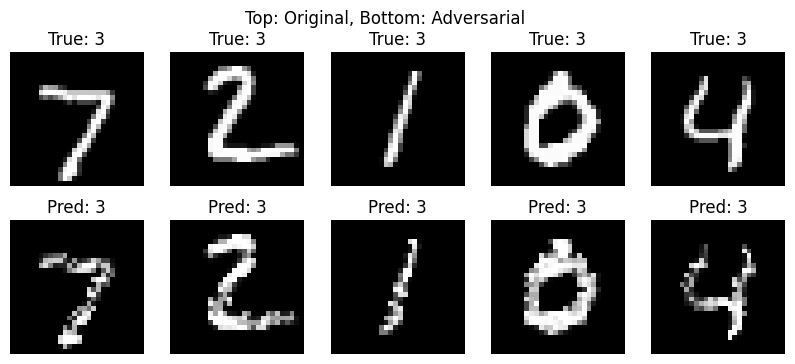

In [14]:
desired_target = torch.zeros(1000, dtype=torch.int32)+3
perturbed_data_cw = cw_attack(model, data, desired_target, c=100.0, steps=300, kappa=2) 
output_cw = model(perturbed_data_cw)
pred_cw = output_cw.argmax(dim=1)
misclassified_cw = (pred_cw != desired_target)
print(f"Misclassification rate: {misclassified_cw.float().mean().item()*100:.2f}%")
plot_adversarial_examples(data, perturbed_data_cw, desired_target, pred_cw)